# 1. Introducció
Aquest projecte consisteix en predir si una empresa caurà en fallida o no a partir de les dades que conté el conjunt de dades, anomenat [Company Bankruptcy Prediction](https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction).

Aquest dataset utilitza dades extretes del Taiwan Economic Journal entre els anys 1999 i 2009. Així, per determinar quan una empresa és fallida (Bankruptcy = 1) s'utilitzen les regulacions comercials definides a la Borsa de Valors de Taiwan.

El conjunt de dades està format per 6819 registres, amb 96 atributs cadascun d'ells. D'aquests, 95 atributs s'utilitzaran com a característiques d'entrada al model, mentre que l'atribut "Bankrupt?" és l'atribut objectiu o *target* que es vol predir.

In [15]:
import pandas as pd
import seaborn as sns
import time
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from joblib import dump
from random import randint

# 2. Anàlisi de dades
Inicialment, s'han processat les dades per poder tenir una visió global d'elles, comprendre quines són les seves característiques i fer-les comparables entre elles per poder entrenar correctament els models que, posteriorment, intentaran fer les prediccions a partir d'aquestes dades processades.

In [16]:
dataset = pd.read_csv('../data/archive/data.csv', header=0, delimiter=',')
print(dataset.head())

   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

Com es pot observar a continuació, la gran majoria dels atributs és de tipus float64, mentre que únicament 3 d'ells són de tipus int64. A més, cal destacar que, segurament degut a que són dades de caràcter oficial, no hi ha cap valor inexistent al conjunt de dades, la qual cosa aporta un gran avantatge ja que, encara que algunes d'elles puguin contenir errors de diversos tipus (d'introducció, de mesura, de càlcul, etc.), no s'han de fer suposicions ni omplir buits de dades.

In [17]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

A continuació es pot veure la dimensionalitat del dataset, a més de la dimensionalitat de les variables d'entrada i de la variable objectiu per separat.

In [18]:
data = dataset.values
x_data = data[:, :-1]  # Característiques d'entrada
y_data = data[:, 0]  # Target
print("DataFrame dimensionality: {}:".format(dataset.shape))
print("Features (X) dimensionality: {}".format(x_data.shape))
print("Target (Y) dimensionality: {}".format(y_data.shape))

DataFrame dimensionality: (6819, 96):
Features (X) dimensionality: (6819, 95)
Target (Y) dimensionality: (6819,)


Abans de realitzar el preprocessat de les dades, una de les primeres accions que s'ha dur a terme ha estat comprovar si les dades del dataset estan balancejades. Com es pot veure, no ho estan (només el 3,23% de les dades són d'empreses fallides).

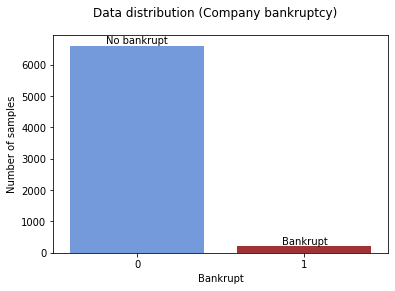

In [19]:
ax = sns.countplot(x="Bankrupt?", data=dataset, palette={0: 'cornflowerblue', 1: "firebrick"})
plt.suptitle("Data distribution (Company bankruptcy)")
label = ["No bankrupt", "Bankrupt"]
ax.bar_label(container=ax.containers[0], labels=label)
plt.xlabel('Bankrupt')
plt.ylabel('Number of samples')
plt.show()

Finalment, s'ha creat una Matriu de Correlació de Pearson per determinar quins atributs tenen més relació amb l'atribut objectiu, i el resultat ha estat que cap atribut té una relació notable, ja sigui directa o inversa, en la predicció de l'atribut objeciu.

<Figure size 432x288 with 0 Axes>

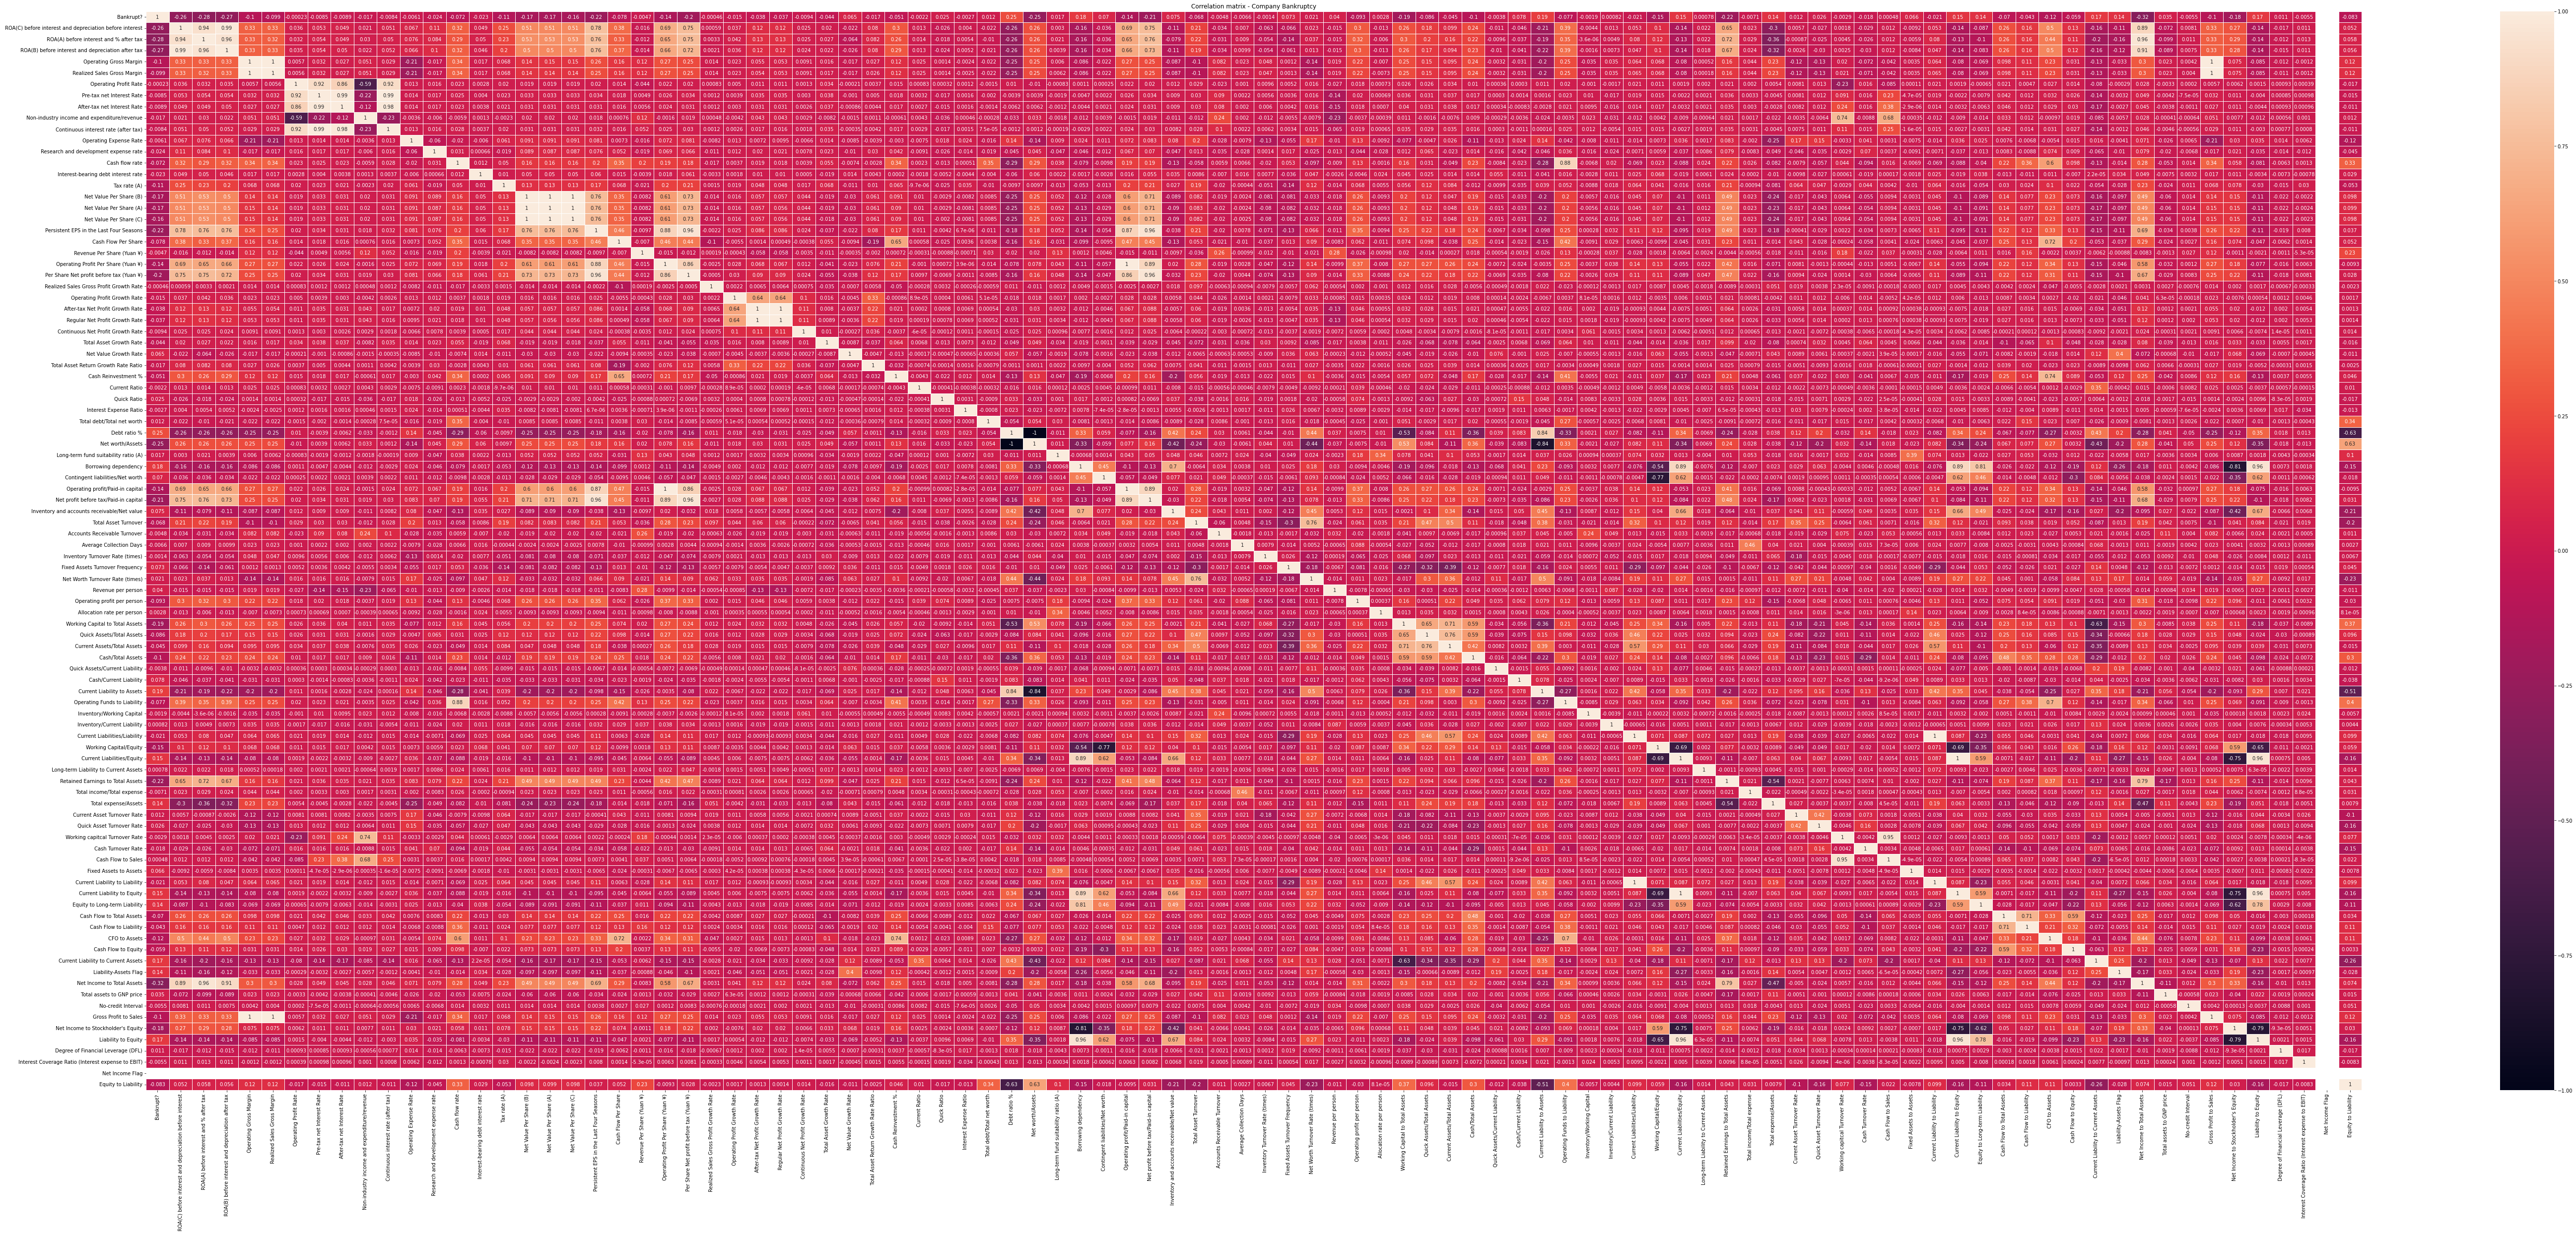

In [20]:
plt.figure()
fig, ax = plt.subplots(figsize=(100, 40))  # figsize controla l'amplada i alçada de les cel·les de la matriu
plt.title("Correlation matrix - Company Bankruptcy")
sns.heatmap(dataset.corr(), annot=True, linewidths=.5, ax=ax)
plt.show()

# 3. Preprocessament de dades
Després de realitzar l'exploració de les dades per conèixer què conté el dataset, s'han processat les dades per poder tenir una visió global d'elles, comprendre quines són les seves característiques i fer-les comparables entre elles per poder entrenar correctament els models que, posteriorment, intentaran fer les prediccions a partir d'aquestes dades processades.
A continuació s'elimina l'atribut NetIncomeFlag, ja que per a tots els registres el seu valor és 1.

In [21]:
# preprocessing
dataset.columns = dataset.columns.str.replace(' ', '')
dataset = dataset.drop('NetIncomeFlag', axis=1)

Una vegada s'ha comprovat que no hi ha valors nuls i que les dades que conté el dataset són útils per a l'entrenament, cal separar-les per fer la validació amb dades amb les quals no han entrenat els models.

In [22]:
x_data = dataset.values[:, 1:]  # Característiques
y_data = dataset.values[:, 0]  # Variable objectiu (target)
# Fa el split de les dades d'entrenament i validació.
x_t, x_v, y_t, y_v = train_test_split(x_data, y_data, train_size=0.8)

Finalment, quan ja tenim les dades separades, llavors es pot procedir a estandarditzar-les.

In [23]:
scaler = MinMaxScaler()
x_t_norm = scaler.fit_transform(x_t)
x_v_norm = scaler.transform(x_v)

# 4. Classificadors
Després de processar les dades, aquestes ja es poden utilitzar pels classificadors. Així, els classificadors de scikit Learn que s'han utilitzat són: LogisticRegression, SVC, KNeighborsClassifier i RandomForestClassifier.
Tots ells s'han utilitzat com a estimadors d'entrada del mecanisme de cerca d'hiperparàmetres GridSearch (GridSearchCV), el qual ha permès trobar els millors hiperparàmetres per cadascun dels classificadors per ajustar-se a les dades del dataset.
Però, per al propòsit d'aquest notebook, s'executen directament els classificadors amb els hiperparàmetres trobats amb GridSearch en execucions anteriors (es pot trobar la implementació completa al fitxer `src/main.py` del [projecte](https://github.com/agusmp97/APC-Company_Bankruptcy_Prediction).

In [24]:
lr = LogisticRegression(C=1.0, fit_intercept=True, penalty='l2', tol=0.001, solver='lbfgs', max_iter=10000000)
lr.fit(x_t_norm, y_t)  # Entrena el model
lr_preds = lr.predict(x_v_norm)
print("LR prediction metrics: \n{}".format(metrics.classification_report(y_true=y_v, y_pred=lr_preds)))

LR prediction metrics: 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1316
         1.0       0.83      0.10      0.19        48

    accuracy                           0.97      1364
   macro avg       0.90      0.55      0.58      1364
weighted avg       0.96      0.97      0.96      1364



In [ ]:
svc = svm.SVC(C=1.0, kernel='linear', degree=3, probability=True)
svc.fit(x_t_norm, y_t)  # Entrena el model
svc_preds = svc.predict(x_v_norm)
print("SVC prediction metrics: \n{}".format(metrics.classification_report(y_true=y_v, y_pred=svc_preds)))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, p=1, weights='uniform', algorithm='auto')
knn.fit(x_t_norm, y_t)  # Entrena el model
knn_preds = knn.predict(x_v_norm)
print("KNN prediction metrics: \n{}".format(metrics.classification_report(y_true=y_v, y_pred=knn_preds)))

In [ ]:
rfc = RandomForestClassifier(criterion='gini', max_depth=8, max_features='sqrt', n_estimators=200)
rfc.fit(x_t_norm, y_t)  # Entrena el model
rfc_preds = knn.predict(x_v_norm)
print("RFC prediction metrics: \n{}".format(metrics.classification_report(y_true=y_v, y_pred=rfc_preds)))

El millor model que s'ha aconseguit ha estat el KNN, ja que, encara que els resultats de les prediccions són molt semblants als altres models, el temps de trobar els millors hiperparàmetres per al model és notablement inferior.
En comparació amb l'estat de l'art i els altres treballs que s'han analitzat, els models implementats en aquest projecte obtenen uns resultats similars als explorats. Això és degut a les poques dades d'empreses fallides que conté el dataset, pel que no es poden optimitzar gaire més els models sense fer un resampling de les dades.

Així, cal destacar que com les dades estan tan desbalancejades (només un 3,23% de les empreses són fallides), és complex per als classificadors predir amb un gran nombre d'encerts les empreses que són fallides, ja que no es disposen de dades suficients d'aquest tipus que permetin fer un entrenament exhaustiu.

# 5. Conclusions i treball futur

Com a millora important d'aquest projecte cal destacar la obtenció de dades d'empreses fallides. Això vol dir que, si no es poden obtenir suficients dades reals d'empreses fallides, s'ha d'utilitzar algun mecanisme de generació de dades fictícies per tal de balancejar el conjunt de dades i poder entrenar millor els models.

Durant el desenvolupament actual del projecte, s'han realitzat proves amb tècniques senzilles de *resampling* de les dades, el que vol dir que s'ha utilitzat la utilitat `resample` de `sklearn.utils`, però no s'han obtingut bons resultats, ja que el que fa aquesta utilitat és duplicar, aleatòriament, les mostres que compleixen una certa condició. Però, amb aquest mecanisme, i degut a que hi ha tan poques dades on l'empresa cau en fallida, respecte de les que no cauen en fallida, que els models entrenats amb aquest mecanisme patien un *overfitting* molt important, i els resultats, per tant, no eren vàlids per poder generalitzar amb el model.